In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install -qq transformers
!pip install -qq datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tqdm import tqdm
import gc
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [55]:
!pip install lion-pytorch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [56]:
from lion_pytorch import Lion

In [57]:
df = pd.read_csv('/kaggle/input/transformer-hw-df/music_album_reviews.csv')

In [58]:
df

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0
...,...,...
80266,my favorites here are the steamy lady cab driv...,3.0
80267,prince would have been well-advised to make th...,4.5
80268,you know you cannot say its not a classic beca...,3.5
80269,the classic prince album.,5.0


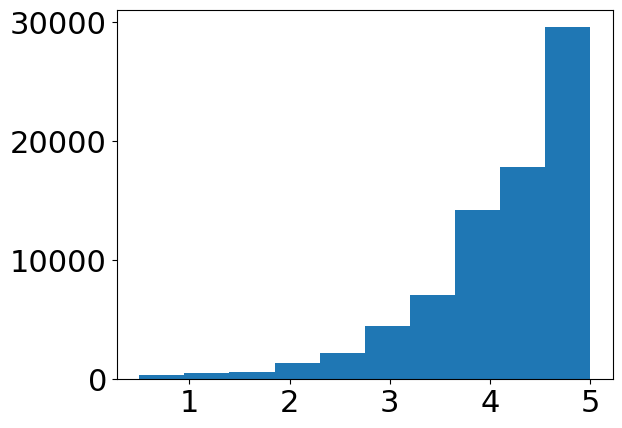

In [59]:
plt.hist(df['Rating'], bins=10)
plt.show()

In [60]:
df['Rating'].value_counts()

Rating
5.0    29534
4.5    17793
4.0    14213
3.5     7048
3.0     4430
2.5     2210
2.0     1396
1.5      640
1.0      525
0.5      398
Name: count, dtype: int64

In [61]:
df.isna().sum()

Review      26
Rating    2084
dtype: int64

In [62]:
df = df.dropna()

In [64]:
df['Rating'] = (df['Rating']*2 - 1).astype(int)

/tmp/ipykernel_34/362231034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating'] = (df['Rating']*2 - 1).astype(int)


In [67]:
df['Rating'].unique()

array([9, 8, 7, 4, 3, 5, 2, 6, 0, 1])

In [68]:
def make_equal(data):    
    ind = []
    data = data.reset_index(drop=True).copy()
    for r in data.Rating.unique():
        print(r)
        ind += list(data[data.Rating == r].sample(397).index)
    return data.iloc[ind]            
df = make_equal(df)

9
8
7
4
3
5
2
6
0
1


In [69]:
df['labels'] = df['Rating']
df.drop(columns=['Rating'], inplace=True)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

In [71]:
df['labels'].unique()

array([9, 8, 7, 4, 3, 5, 2, 6, 0, 1])

In [167]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=10)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [168]:
X_train.to_csv('/kaggle/working/train.csv', index=False)
X_test.to_csv('/kaggle/working/test.csv', index=False)

dataset = load_dataset('csv', data_files={'train': '/kaggle/working/train.csv', 'test': '/kaggle/working/test.csv'})
dataset = dataset.map(lambda e: tokenizer(e['Review'], truncation = True, max_length=256, padding='max_length'), batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/794 [00:00<?, ? examples/s]

In [169]:
# это стандартные колонки для формата пайторча, все кроме них убираем
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  #
# убираем их из загрузчика
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

In [170]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3176
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 794
    })
})

In [171]:
dataset.set_format(type='torch', columns=['labels', 'input_ids', 'attention_mask'], device='cuda')

In [172]:
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)

In [173]:
# optimizer = AdamW(model.parameters(), lr=2e-3)
optimizer = Lion(model.parameters(), lr=6e-5, weight_decay=1e-5)
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [174]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [175]:
next(iter(train_dataloader))

{'labels': tensor([3, 7, 2, 2, 6, 2, 2, 7], device='cuda:0'),
 'input_ids': tensor([[    0, 21996,  6769,  ...,     1,     1,     1],
         [    0,    29, 12363,  ...,     1,     1,     1],
         [    0,   718,  7434,  ...,     1,     1,     1],
         ...,
         [    0,  2362, 16490,  ...,     1,     1,     1],
         [    0, 14746,   939,  ..., 13516,  2143,     2],
         [    0,  7885, 11057,  ...,     1,     1,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [176]:
model


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [177]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from tqdm.auto import tqdm
from collections import deque

best_f1 = 0.
avg_loss = deque([], maxlen=30)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True
    
# for param in model.pre_classifier.parameters():
#     param.requires_grad = True
    
# for param in model.dropout.parameters():
#     param.requires_grad = True
# проходимся по всем эпохам
for epoch in range(num_epochs):
    print(40*'-', '\nepoch', epoch+1)
    model.train()

    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            model.train()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            avg_loss.append(loss.item())
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    print('\nvalidating')
    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'macro')['precision'])
        print('Test recall:', recall.compute(average = 'macro')['recall'])
        f1_weighted = f1.compute(average = 'macro')['f1']
        print('Test f1:', f1_weighted, '\n')
        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=256")

    model.train()

---------------------------------------- 
epoch 1


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.10075566750629723
Test precision: 0.017807544568107948
Test recall: 0.10126582278481014
Test f1: 0.020546006066734075 

---------------------------------------- 
epoch 2


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.10075566750629723
Test precision: 0.10997474747474748
Test recall: 0.10126582278481014
Test f1: 0.020640068886337546 

---------------------------------------- 
epoch 3


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.12846347607052896
Test precision: 0.10908880363177717
Test recall: 0.12837025316455697
Test f1: 0.054787199536963115 

---------------------------------------- 
epoch 4


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.14609571788413098
Test precision: 0.1184090722336669
Test recall: 0.14653481012658226
Test f1: 0.07734481057689523 

---------------------------------------- 
epoch 5


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.2052896725440806
Test precision: 0.1351379073521476
Test recall: 0.20560126582278482
Test f1: 0.14253996010321732 

---------------------------------------- 
epoch 6


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.2040302267002519
Test precision: 0.2085036569204775
Test recall: 0.20405063291139242
Test f1: 0.16824924363592034 

---------------------------------------- 
epoch 7


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.21662468513853905
Test precision: 0.16069673335714776
Test recall: 0.21664556962025316
Test f1: 0.1661394247646118 

---------------------------------------- 
epoch 8


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.18639798488664988
Test precision: 0.12242549167983832
Test recall: 0.1872626582278481
Test f1: 0.11382707625888182 

---------------------------------------- 
epoch 9


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.21788413098236775
Test precision: 0.1996924564931119
Test recall: 0.2178164556962025
Test f1: 0.1617050348801113 

---------------------------------------- 
epoch 10


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.20654911838790932
Test precision: 0.1602090656766907
Test recall: 0.20599683544303798
Test f1: 0.16059085430249037 

---------------------------------------- 
epoch 11


  0%|          | 0/397 [00:00<?, ?batch/s]


validating


  0%|          | 0/100 [00:00<?, ?it/s]

weighted summary:
Test acc: 0.2052896725440806
Test precision: 0.15316511031082342
Test recall: 0.20507911392405065
Test f1: 0.1630630071717037 

---------------------------------------- 
epoch 12


  0%|          | 0/397 [00:00<?, ?batch/s]

In [181]:
true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

  0%|          | 0/100 [00:00<?, ?it/s]

In [182]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.29      0.43      0.34        79
           1       0.00      0.00      0.00        79
           2       0.11      0.03      0.04        79
           3       0.16      0.30      0.21        80
           4       0.20      0.09      0.12        80
           5       0.05      0.01      0.02        79
           6       0.15      0.12      0.14        80
           7       0.16      0.29      0.20        79
           8       0.17      0.19      0.18        79
           9       0.29      0.53      0.37        80

    accuracy                           0.20       794
   macro avg       0.16      0.20      0.16       794
weighted avg       0.16      0.20      0.16       794

